# Training Notebook: Cat-Dog Image Classification

Author: **hnthap**

In [1]:
from datetime import datetime, timezone
import gc
import os
import random

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models
import torchvision.transforms as transforms


plt.style.use('default')

In [2]:
!python -c "import sys; print('python', sys.version)"
!python -c "import PIL; print('PIL', PIL.__version__)"
!python -c "import numpy; print('numpy', numpy.__version__)"
!python -c "import polars; print('polars', polars.__version__)"
!python -c "import torch; import torchvision; print('torch', torch.__version__); print('torchvision', torchvision.__version__)"

python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
PIL 10.3.0
numpy 2.0.1
polars 1.21.0
torch 2.5.1
torchvision 0.20.1


In [3]:
# Ensure reproducibility

seed = 2025

def ensure_reproducibility(seed=seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    random.seed(seed)
    np.random.seed(seed)

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

ensure_reproducibility()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cpu':
    print('CUDA Device:', torch.cuda.get_device_name(device))

CUDA Device: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
def flush(*, verbose=True):
    if verbose:
        print('GC collected', gc.collect())
    else:
        gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

flush()

GC collected 42


In [6]:
def now_str():
    '''
    Returns a string representation of the current time (UTC).
    '''
    return datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S-%f')

now_str()

'20250314-113257-109881'

In [7]:
CHECKPOINT_DIR = '../checkpoint/'


def save_model(model, optimizer, model_name='model', **kwargs):
    checkpoint_path = os.path.join(
        CHECKPOINT_DIR, f'ckpt-{model_name}-{now_str()}.pth'
    )
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        **kwargs
    }, checkpoint_path)
    print('Model saved:', checkpoint_path)
    return checkpoint_path


def load_model(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint['model_state_dict']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    del checkpoint['optimizer_state_dict']
    print('Model loaded:', checkpoint_path)
    return checkpoint


def load_checkpoint_result(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    del checkpoint['model_state_dict']
    del checkpoint['optimizer_state_dict']
    return checkpoint


os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Data

In [8]:
IMAGE_DIR = '../data/PetImages/'

In [9]:
# Remove corrupted cat images

cat_image_filenames = sorted(os.listdir(os.path.join(IMAGE_DIR, 'Cat')))

corrupted_image_indices = set()
for i, filename in tqdm(enumerate(cat_image_filenames),
                        total=len(cat_image_filenames)):
    image_path = os.path.join(IMAGE_DIR, 'Cat', filename)
    try:
        with Image.open(image_path) as image:
            image.verify()
    except:
        corrupted_image_indices.add(i)
        print('corrupted image [%d]: %s' % (i, image_path))

cat_image_filenames = [
    filename for i, filename in enumerate(cat_image_filenames)
    if i not in corrupted_image_indices
]

print('# cat images:', len(cat_image_filenames))

  0%|          | 0/12501 [00:00<?, ?it/s]

corrupted image [8790]: ../data/PetImages/Cat\666.jpg
corrupted image [12500]: ../data/PetImages/Cat\Thumbs.db
# cat images: 12499


In [10]:
# Remove corrupted dog images

dog_image_filenames = sorted(os.listdir(os.path.join(IMAGE_DIR, 'Dog')))

corrupted_image_indices = set()
for i, filename in tqdm(enumerate(dog_image_filenames),
                        total=len(dog_image_filenames)):
    image_path = os.path.join(IMAGE_DIR, 'Dog', filename)
    try:
        with Image.open(image_path) as image:
            image.verify()
    except:
        corrupted_image_indices.add(i)
        print('corrupted image [%d]: %s' % (i, image_path))

dog_image_filenames = [
    filename for i, filename in enumerate(dog_image_filenames)
    if i not in corrupted_image_indices
]

print('# dog images:', len(dog_image_filenames))

  0%|          | 0/12501 [00:00<?, ?it/s]

corrupted image [1895]: ../data/PetImages/Dog\11702.jpg


c:\Users\C15TQK\miniconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


corrupted image [12500]: ../data/PetImages/Dog\Thumbs.db
# dog images: 12499


In [11]:
flush()

GC collected 7


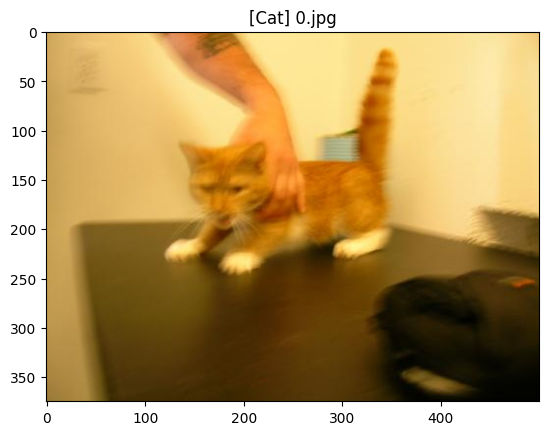

In [12]:
with Image.open(os.path.join(IMAGE_DIR, 'Cat', cat_image_filenames[0])) as image:
    plt.imshow(image.convert('RGB'))

plt.title('[Cat] ' + cat_image_filenames[0])
plt.show()

In [13]:
cat_dog_df = (
    pl.LazyFrame([
        { 'label': 'Dog', 'filename': dog_image_filenames },
        { 'label': 'Cat', 'filename': cat_image_filenames },
    ])
    .explode('filename')
    .with_columns((pl.col('label') == 'Cat').cast(pl.Int8).alias('is_cat'))
    .select('label', 'filename', 'is_cat')
    .collect()
)

splits = (
    ['train'] * (len(cat_dog_df) - 3000)
    + ['test'] * 2000
    + ['val'] * 1000
)
random.Random(seed).shuffle(splits)

cat_dog_df = cat_dog_df.with_columns(pl.Series(splits).alias('split'))

del splits

print(cat_dog_df.filter(pl.col('split') == 'train').sample(3, seed=seed * 200))
print(cat_dog_df.filter(pl.col('split') == 'test').sample(3, seed=seed))
print(cat_dog_df.filter(pl.col('split') == 'val').sample(3, seed=seed))

shape: (3, 4)
┌───────┬──────────┬────────┬───────┐
│ label ┆ filename ┆ is_cat ┆ split │
│ ---   ┆ ---      ┆ ---    ┆ ---   │
│ str   ┆ str      ┆ i8     ┆ str   │
╞═══════╪══════════╪════════╪═══════╡
│ Cat   ┆ 1024.jpg ┆ 1      ┆ train │
│ Dog   ┆ 9936.jpg ┆ 0      ┆ train │
│ Dog   ┆ 6711.jpg ┆ 0      ┆ train │
└───────┴──────────┴────────┴───────┘
shape: (3, 4)
┌───────┬──────────┬────────┬───────┐
│ label ┆ filename ┆ is_cat ┆ split │
│ ---   ┆ ---      ┆ ---    ┆ ---   │
│ str   ┆ str      ┆ i8     ┆ str   │
╞═══════╪══════════╪════════╪═══════╡
│ Dog   ┆ 2872.jpg ┆ 0      ┆ test  │
│ Dog   ┆ 7470.jpg ┆ 0      ┆ test  │
│ Dog   ┆ 7201.jpg ┆ 0      ┆ test  │
└───────┴──────────┴────────┴───────┘
shape: (3, 4)
┌───────┬──────────┬────────┬───────┐
│ label ┆ filename ┆ is_cat ┆ split │
│ ---   ┆ ---      ┆ ---    ┆ ---   │
│ str   ┆ str      ┆ i8     ┆ str   │
╞═══════╪══════════╪════════╪═══════╡
│ Dog   ┆ 2162.jpg ┆ 0      ┆ val   │
│ Dog   ┆ 718.jpg  ┆ 0      ┆ val   │
│ Dog   

In [14]:
cat_dog_df.write_csv('cat-dog.csv')

## Preprocessing

In [12]:
class CatDogDataset(Dataset):

    def __init__(self, image_dir, data, transform=None):
        self.image_dir = image_dir
        self.data = data
        self.transform = transform


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        row = self.data.row(idx)
        file_path = os.path.join(self.image_dir, row[0], row[1])
        with Image.open(file_path, 'r').convert('RGB') as image:
            if self.transform:
                image = self.transform(image)
            return image, row[2]  # image, is_cat columns
        

    def get_image_path(self, idx):
        row = self.data.row(idx)
        return os.path.join(self.image_dir, row[0], row[1])


In [13]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [14]:
train_dataset = CatDogDataset(
    IMAGE_DIR, cat_dog_df.filter(pl.col('split') == 'train'), transform
)
test_dataset = CatDogDataset(
    IMAGE_DIR, cat_dog_df.filter(pl.col('split') == 'test'), transform
)
val_dataset = CatDogDataset(
    IMAGE_DIR, cat_dog_df.filter(pl.col('split') == 'val'), transform
)

print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

Train data size: 21998
Test data size: 2000
Validation data size: 1000


Input shape: torch.Size([3, 224, 224])
Label: 1


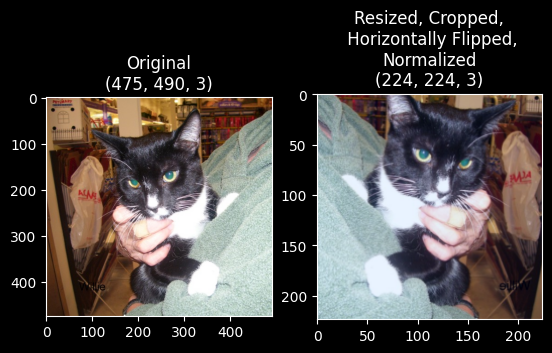

In [15]:
idx = 16_500

if idx < 0 or idx >= len(train_dataset):
    raise IndexError()

inp, label = train_dataset[idx]
print('Input shape:', inp.size())
print('Label:', label)

inp = inp.detach().numpy()
inp = ((inp - inp.min()) * 255 / (inp.max() - inp.min() + 1e-9)).astype(int)
inp = np.moveaxis(inp, 0, -1)

plt.subplot(1, 2, 1)
with Image.open(train_dataset.get_image_path(idx), 'r') as image:
    plt.imshow(image.convert('RGB'))
    plt.title('Original\n' + str(np.asarray(image.convert('RGB')).shape))
plt.subplot(1, 2, 2)
plt.imshow(inp)
plt.title('Resized, Cropped,\n Horizontally Flipped,\nNormalized\n'
          + str(inp.shape))
plt.show()

## Model: EfficientNet-B0

* EfficientNet: [paper](https://arxiv.org/pdf/1905.11946)
* MnasNet (EfficientNet architecture): [paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Tan_MnasNet_Platform-Aware_Neural_Architecture_Search_for_Mobile_CVPR_2019_paper.pdf)

In [ ]:
class CatDogModelA(nn.Module):

    def __init__(self):
        super(CatDogModelA, self).__init__()
        self.net = torchvision.models.efficientnet_b0(
            weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        for i in range(6):
            for param in self.net.features[i].parameters():
                param.requires_grad = False
        self.net.classifier[1] = nn.Linear(self.net.classifier[1].in_features, 2)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.net(x)
        x = self.softmax(x)
        return x

In [54]:
flush()
ensure_reproducibility()

model_a = CatDogModelA().to(device)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_a.parameters(), lr=0.001)

num_epochs = 5

history = { 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }
best_checkpoint = None
latest_checkpoint = None

for epoch in range(num_epochs):

    # Train
    model_a.train()
    running_loss = 0.0
    correct_count = 0
    total_count = 1e-12  # A very small number to avoid division by zero
    for inps, labels in tqdm(train_dataloader):
        inps = inps.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_a(inps)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_count += labels.size(0)
        correct_count += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = 100.0 * correct_count / total_count
    print('Epoch %d/%d | Train loss: %.4f | Train accuracy: %.4f%% ' % (
        epoch + 1, num_epochs, epoch_loss, epoch_accuracy
    ), end='')
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_accuracy)

    # Validate
    model_a.eval()
    running_loss = 0.0
    correct_count = 0
    total_count = 1e-12  # A very small number to avoid division by zero
    with torch.no_grad():
        for inps, labels in val_dataloader:
            inps = inps.to(device)
            labels = labels.to(device)
            outputs = model_a(inps)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_count += labels.size(0)
            correct_count += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(val_dataloader)
    epoch_accuracy = 100.0 * correct_count / total_count
    print('Val loss: %.4f | Val accuracy: %.4f%%' % (epoch_loss, epoch_accuracy))
    history['val_loss'].append(epoch_loss)
    history['val_acc'].append(epoch_accuracy)

    # Save checkpoint if validation result is improved
    latest_checkpoint = save_model(
        model_a, optimizer, 'a',
        train_loss=history['train_loss'][-1],
        train_acc=history['train_acc'][-1],
        val_loss=history['val_loss'][-1],
        val_acc=history['val_acc'][-1],
    )
    print('Save latest checkpoint to %s' % latest_checkpoint)
    if (
        best_checkpoint is None
        or load_checkpoint_result(best_checkpoint)['val_loss'] > epoch_loss
    ):
        best_checkpoint = latest_checkpoint
        print('Save best checkpoint to %s' % best_checkpoint)
    flush(verbose=False)

print('🏁 Training Is All Done!')

GC collected 7493


  0%|          | 0/344 [00:00<?, ?it/s]

c:\Users\C15TQK\miniconda3\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/5 | Train loss: 0.3512 | Train accuracy: 96.1678% Val loss: 0.3394 | Val accuracy: 97.1000%
Model saved: ../checkpoint/ckpt-a-20250314-091438-896866.pth
Save latest checkpoint to ../checkpoint/ckpt-a-20250314-091438-896866.pth
Save best checkpoint to ../checkpoint/ckpt-a-20250314-091438-896866.pth


  0%|          | 0/344 [00:00<?, ?it/s]

Epoch 2/5 | Train loss: 0.3392 | Train accuracy: 97.3725% Val loss: 0.3277 | Val accuracy: 98.6000%
Model saved: ../checkpoint/ckpt-a-20250314-091834-563175.pth
Save latest checkpoint to ../checkpoint/ckpt-a-20250314-091834-563175.pth


C:\Users\C15TQK\AppData\Local\Temp\ipykernel_2772\2339486226.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Save best checkpoint to ../checkpoint/ckpt-a-20250314-091834-563175.pth


  0%|          | 0/344 [00:00<?, ?it/s]

Epoch 3/5 | Train loss: 0.3347 | Train accuracy: 97.7862% Val loss: 0.3300 | Val accuracy: 98.3000%
Model saved: ../checkpoint/ckpt-a-20250314-092225-284798.pth
Save latest checkpoint to ../checkpoint/ckpt-a-20250314-092225-284798.pth


  0%|          | 0/344 [00:00<?, ?it/s]

Epoch 4/5 | Train loss: 0.3313 | Train accuracy: 98.0998% Val loss: 0.3251 | Val accuracy: 98.9000%
Model saved: ../checkpoint/ckpt-a-20250314-092618-383242.pth
Save latest checkpoint to ../checkpoint/ckpt-a-20250314-092618-383242.pth
Save best checkpoint to ../checkpoint/ckpt-a-20250314-092618-383242.pth


  0%|          | 0/344 [00:00<?, ?it/s]

Epoch 5/5 | Train loss: 0.3292 | Train accuracy: 98.3726% Val loss: 0.3295 | Val accuracy: 98.3000%
Model saved: ../checkpoint/ckpt-a-20250314-092947-330244.pth
Save latest checkpoint to ../checkpoint/ckpt-a-20250314-092947-330244.pth
🏁 Training Is All Done!


Best model: `../checkpoint/ckpt-a-20250314-092618-383242.pth`

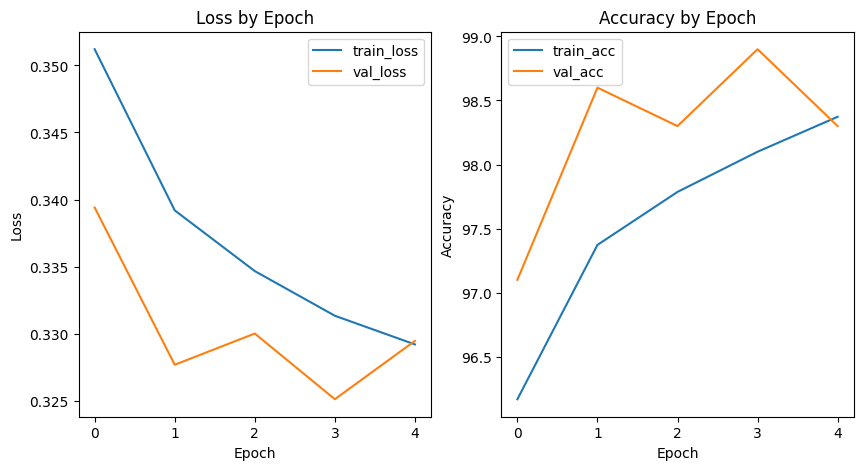

In [60]:
plt.figure(figsize=(10, 5))
for key, scores in history.items():
    if key.endswith('_loss'):
        plt.subplot(1, 2, 1)
    else:
        plt.subplot(1, 2, 2)
    plt.plot(scores, label=key)
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()
plt.show()